# $\textbf{Predicting LFSR States Using Feedforward Neural Networks}$
$\text{Author: Ryan Burns}$

$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$

### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, identity, hstack, vstack, shape
from numpy import expand_dims, zeros, correlate, linspace, arange, max

# Galois / LFSR utilities
from galois_tools import *
from m_sequence_viz import *
from lfsr_network_viz import *
from ml_utils import *

# Plotting functionality
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

# Tensorflow/Keras functionality
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

### $\textbf{Plotting Macro (Requires IPython)}$

In [2]:
%matplotlib notebook

### $\textbf{Specify LFSR & Neural Net Parameters}$

In [3]:
###########################
# Specify LFSR parameters #
###########################

# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

# Primitive polynomial choice
p = 16 # (index in catalog)

###############################
# Network training parameters #
###############################

# Number of RMSprop training epochs
N_epoch = 160#00

# Batch size equal to m-sequence length
N_batch = 2**deg - 1

# Learning rate for RMSprop
learning_rate = 0.001

#########################
# Behavioral parameters #
#########################

# Turn ON/OFF correlation plot
plot_correlations = True

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [4]:
#############################################################
# Load coeff. of primitive polynomials over GF(2) from file #
#############################################################

# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg)

###########################################################
# Generate linear feedback shift registers w/ polynomials #
###########################################################

# Define a bank of LFSRs - 1 per polynomial in the catalog
LFSRs = [LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))]

### $\textbf{Visualize Auto- & Cross-Correlations of Two m-Sequences}$

<IPython.core.display.Javascript object>


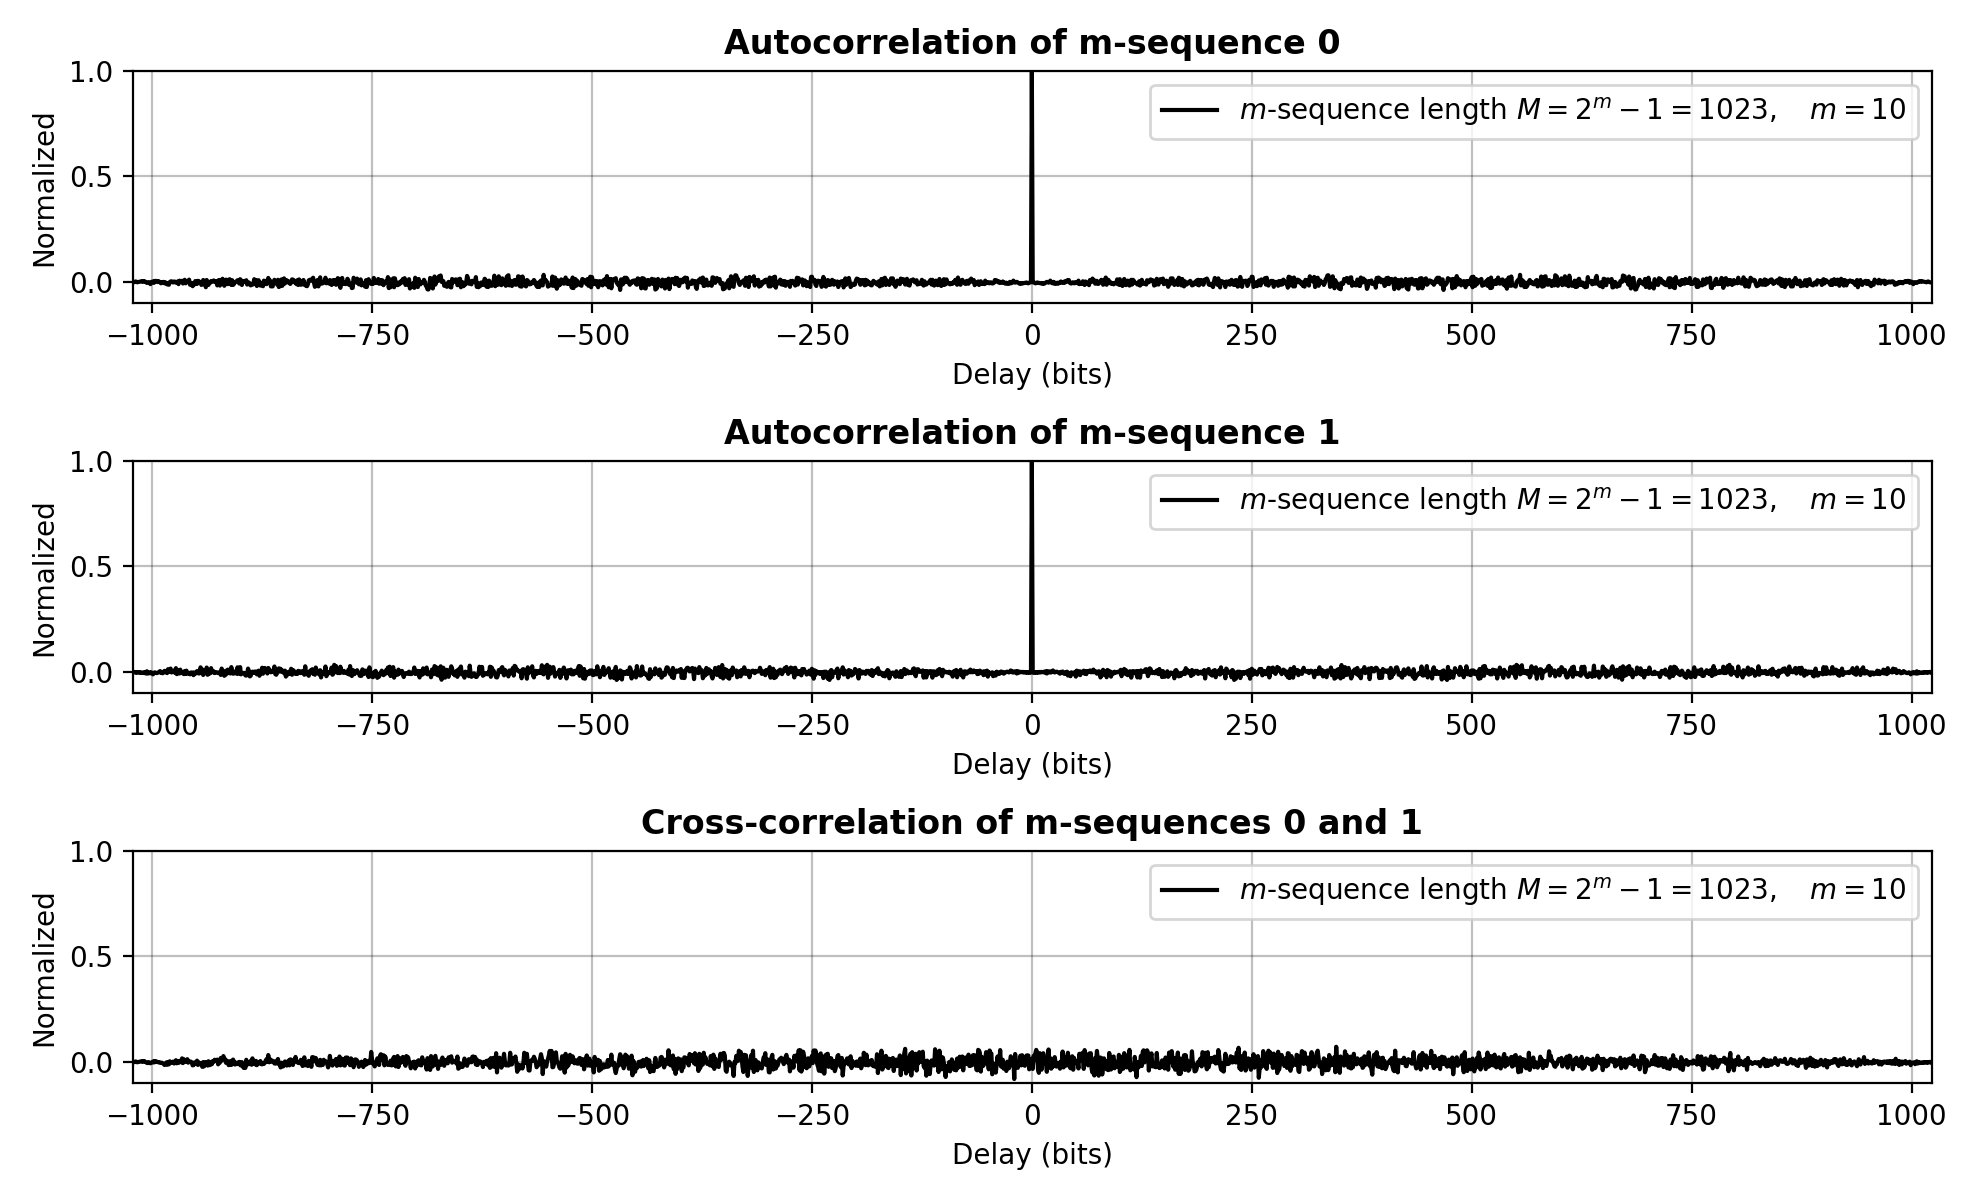

In [5]:
# Optional correlation plot...
if plot_correlations:

    ##################################################
    # Generate m-sequences for each LFSR in the bank #
    ##################################################

    # Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
    m_sequences = vstack(tuple(register.m_sequence() for register in LFSRs))

    # Convert m-sequences from logical {0,1} to algebraic {-1,+1} representation
    algebraic_m_sequences = m_sequences.astype('float64') * 2 - 1

    ###################################################
    # Visualize correlation properties of m-sequences #
    ###################################################

    # Plot the correlations of the 1st 2 m-sequences generated above
    correlation_example(m_sequence0=algebraic_m_sequences[p,:], 
        m_sequence1=algebraic_m_sequences[p + 1,:],  deg=deg)

### $\textbf{Form Observations of }n^{\text{th}}\textbf{ LFSR State for Prediction of }(n + 1)^\text{st}\textbf{ State, for }n=0,1,2,\ldots$

In [6]:
#########################################################
# Buffer in b[n] a total of 2^deg + deg m-sequence bits #
#########################################################

# Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
b = vstack(tuple(register.stream(2**deg + deg) for register in LFSRs))

########################################################
# n'th LFSR register state observations, n = 0,1,2,... #
########################################################

# Input LFSR windows (deg-bit observation vectors)
X = array([b[p,n:(n + deg)] for n in range(b.shape[1] - deg - 1)])

############################################################
# (n+1)'st LFSR register state observations, n = 0,1,2,... #
############################################################

# Target LFSR windows, 1 epoch into future from X
Y = array([b[p,(n + 1):(1 + n + deg)] for n in range(b.shape[1] - deg - 1)])

### $\textbf{Define Feedforward Binary Neural Network}$

In [7]:
# Use Keras to define feedforward binary neural network, with
# two sigmoidal layers (without bias terms) for estimation of
# the LFSR state vector at epoch n + 1 from the state at epoch n
model = feedforward_lfsr_predictor(deg=deg, 
    learning_rate=learning_rate, print_summary=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden (Dense)               (None, 20)                200       
_________________________________________________________________
output (Dense)               (None, 10)                200       
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


### $\textbf{Fit Sigmoid Model to Predict Register State }n + 1\textbf{ from State }n$

In [8]:
# Model training
model.fit(
    
    # Input dataset
    x=X, # state vectot "observation" bits
    y=Y, # future-state predicted bits
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=0, # (use everything)
    
    # False for time series
    shuffle=False,
    
    # Parallelize job across 2 workers
    workers=1,
    use_multiprocessing=False);

Train on 1023 samples
Epoch 1/160
1023/1023 [==============================] - 1s 1ms/sample - loss: 0.7564 - true_positives: 2008.0000 - true_negatives: 3312.0000 - false_positives: 1798.0000 - false_negatives: 3112.0000
Epoch 2/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7505 - true_positives: 1994.0000 - true_negatives: 3354.0000 - false_positives: 1756.0000 - false_negatives: 3126.0000
Epoch 3/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7465 - true_positives: 1992.0000 - true_negatives: 3385.0000 - false_positives: 1725.0000 - false_negatives: 3128.0000
Epoch 4/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7433 - true_positives: 1990.0000 - true_negatives: 3402.0000 - false_positives: 1708.0000 - false_negatives: 3130.0000
Epoch 5/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7405 - true_positives: 1989.0000 - true_negatives: 3429.0000 - false_positives: 1681.0000 - false

Epoch 42/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6925 - true_positives: 2135.0000 - true_negatives: 3811.0000 - false_positives: 1299.0000 - false_negatives: 2985.0000
Epoch 43/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6917 - true_positives: 2146.0000 - true_negatives: 3814.0000 - false_positives: 1296.0000 - false_negatives: 2974.0000
Epoch 44/160
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6908 - true_positives: 2153.0000 - true_negatives: 3819.0000 - false_positives: 1291.0000 - false_negatives: 2967.0000
Epoch 45/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6900 - true_positives: 2159.0000 - true_negatives: 3829.0000 - false_positives: 1281.0000 - false_negatives: 2961.0000
Epoch 46/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6892 - true_positives: 2164.0000 - true_negatives: 3842.0000 - false_positives: 1268.0000 - false_negatives: 2956.

Epoch 83/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6653 - true_positives: 2620.0000 - true_negatives: 4147.0000 - false_positives: 963.0000 - false_negatives: 2500.0000
Epoch 84/160
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6647 - true_positives: 2644.0000 - true_negatives: 4152.0000 - false_positives: 958.0000 - false_negatives: 2476.0000
Epoch 85/160
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6642 - true_positives: 2676.0000 - true_negatives: 4148.0000 - false_positives: 962.0000 - false_negatives: 2444.0000
Epoch 86/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6637 - true_positives: 2698.0000 - true_negatives: 4146.0000 - false_positives: 964.0000 - false_negatives: 2422.0000
Epoch 87/160
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6632 - true_positives: 2730.0000 - true_negatives: 4142.0000 - false_positives: 968.0000 - false_negatives: 2390.0000


Epoch 124/160
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6463 - true_positives: 3698.0000 - true_negatives: 3872.0000 - false_positives: 1238.0000 - false_negatives: 1422.0000
Epoch 125/160
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6459 - true_positives: 3710.0000 - true_negatives: 3871.0000 - false_positives: 1239.0000 - false_negatives: 1410.0000
Epoch 126/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6454 - true_positives: 3721.0000 - true_negatives: 3872.0000 - false_positives: 1238.0000 - false_negatives: 1399.0000
Epoch 127/160
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6450 - true_positives: 3734.0000 - true_negatives: 3871.0000 - false_positives: 1239.0000 - false_negatives: 1386.0000
Epoch 128/160
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6446 - true_positives: 3746.0000 - true_negatives: 3868.0000 - false_positives: 1242.0000 - false_negatives: 

### $\textbf{Get Activations of Hidden & Output Layers}$

In [9]:
######################################
# Hidden sigmoidal layer activations #
######################################

# Gather hidden layer outputs from original model
h_layer = model.get_layer('hidden').output

# Separate model to spy on hidden layer activations
hidden_layer_model = Model(inputs=model.input,
    outputs=h_layer)

# Sigmoidal hidden layer outputs / activations
h_activations = hidden_layer_model.predict(X)

######################################
# Output sigmoidal layer activations #
######################################

# Get model output activations
Y_hat = model.predict(X)

### $\textbf{Visualize LFSR State and Feedforward Binary Network}$

<IPython.core.display.Javascript object>


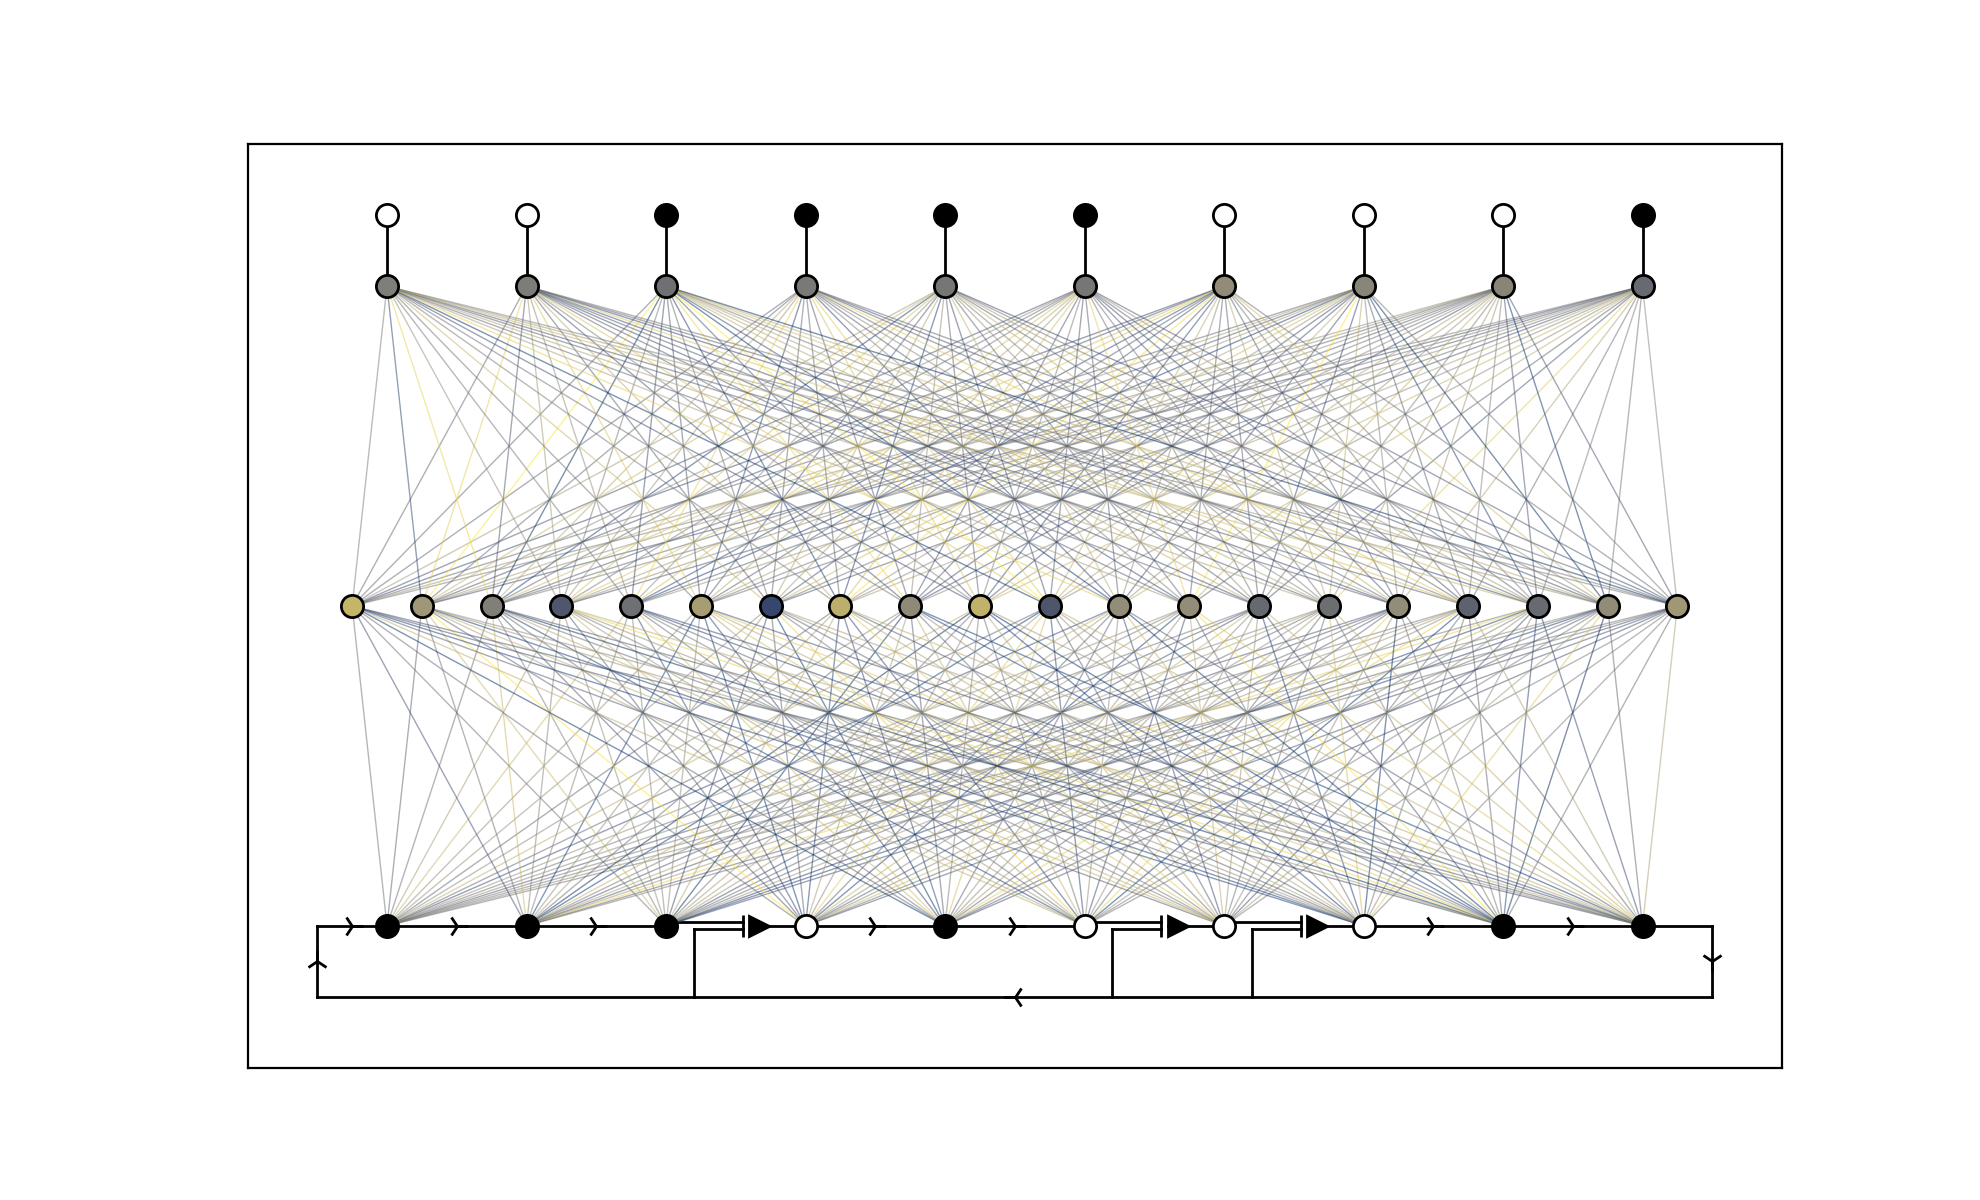

In [10]:
##############################
# Visualization config panel #
##############################

config = {
    'figsize': (9.9, 6),
    'deg': deg,
    'x_mid': (deg - 1) / 2,
    'cmap': 'cividis',
    'y_input': 0,
    'y_hidden': 0.45,
    'y_output': 0.9,
    'y_decision': 1,
    'y_LFSR_loop': -0.1,
    'y_lim': [-0.2, 1.1],
    'num_hidden': 2 * deg,
    'num_input': deg,
    'num_output': deg,
    'node_size': 8,
    'link_width': 1,
    'net_link_alpha': 0.5,
    'arrow_size': 8,
    'net_feedback_linestyle':'--'
}

#################################
# Initialize plot in new figure #
#################################

# New figure
fig = plt.figure(figsize=config['figsize'])

# Draw LFSR corrsponding to tap polynomial
draw_lfsr(taps=str2vec(hex2bin(
    coeff_catalog[p], config['deg'])), 
    deg=config['deg'], 
    x_midpt=config['x_mid'],
    y_register=config['y_input'],
    y_feedback=config['y_LFSR_loop'],
    arrow_size=config['arrow_size'],
    lw=config['link_width'])

# Initialize neural net drawing
input_nodes, hidden_nodes, output_nodes, \
decision_nodes, = init_network_diagram(
    model=model,
    config=config, seed_bits=X[0,:],
    h_activations=h_activations[0,:],
    y_activations=Y_hat[0,:])

###############
# Format axes #
###############

# Define colormap via matplotlib
cmap = plt.get_cmap(config['cmap'])

# Vertical axis span
plt.ylim(config['y_lim']);

# Remove all axis ticks
plt.xticks([]);
plt.yticks([]);

#############
# Animation #
#############

# Run feedforward LFSR prediction network animation
network_animation = FuncAnimation(fig, animate, 
    fargs=[X, Y_hat, h_activations, cmap, input_nodes,
    hidden_nodes,output_nodes, decision_nodes,],
    frames=arange(0, 2**config['deg'] - 1),
    interval=666, blit=True, repeat=False)